# Calculate travel time matrices in R with `r5r`

### Lesson objectives

This tutorial focuses on introducing you how to compute travel time matrices by different travel modes using a relatively new R-package called `r5r`. Travel time data is fundamental information whenever aiming to analyze e.g. accessibility -related questions.

### Library status

`r5r` is still developing fast but it already has many useful functionalities related to spatial accessibility analysis. `r5r` has at the moment more implemented functionalities compared to `r5py`. Eventually, both of these libraries aim to provide a similar set of functionalities. 

## Compute travel time matrices 

When trying to understand the accessibility of a specific location, you typically want to look at travel times between multiple locations (one-to-many). Next, we will learn how to calculate travel time matrices using `r5r` R-package. 

When calculating travel times with `r5r`, you typically need a few datasets:

- **A road network dataset from OpenStreetMap** (OSM) in Protocolbuffer Binary (`.pbf`) format:
  - This data is used for finding the fastest routes and calculating the travel times based on walking, cycling and driving. In addition, this data is used for walking/cycling legs between stops when routing with transit.
  - *Hint*: Sometimes you might need modify the OSM data beforehand, e.g., by cropping the data or adding special costs for travelling (e.g., for considering slope when cycling/walking). When doing this, you should follow the instructions on the [Conveyal website](https://docs.conveyal.com/prepare-inputs#preparing-the-osm-data). For adding customized costs for pedestrian and cycling analyses, see [this repository](https://github.com/RSGInc/ladot_analysis_dataprep).

- **A transit schedule dataset** in General Transit Feed Specification (GTFS.zip) format (optional):
   - This data contains all the necessary information for calculating travel times based on public transport, such as stops, routes, trips and the schedules when the vehicles are passing a specific stop. You can read about the [GTFS standard here](https://developers.google.com/transit/gtfs/reference).
   - *Hint*: `r5r` can also combine multiple GTFS files, as sometimes you might have different GTFS feeds representing, e.g., the bus and metro connections.
   
- **Digital Elevation Model (DEM) data** (optional) in GeoTIFF format (`.tif`):
   - This data is used to calculate impedance for walking and cycling based on street slopes.
   - You can download this data directly from [USGS / NASA](https://lpdaac.usgs.gov/products/srtmgl1v003/) or use [elevatr -package](https://github.com/jhollist/elevatr)


### Sample datasets

In the following tutorial, we use open source datasets for Brighton & Hove:
- The point dataset for this tutorial has been obtained from [WorldPop -project](https://hub.worldpop.org/project/categories?id=3) licensed under a Creative Commons Attribution 4.0 International License.
- The street network is a cropped and filtered extract of OpenStreetMap (© OpenStreetMap contributors, [ODbL license](https://www.openstreetmap.org/copyright))
- The GTFS transport schedule dataset for Brighton are open datasets obtained from:
  - Bus schedules: [Brighton & Hove Bus and Coach Company](https://www.buses.co.uk/open-data) licensed under [Open Government License Version 3.0](https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/).

## Download the datasets

We have prepared a Zip-package with all relevant data that helps you to start working with the tools quickly. You can download and extract the data by executing the following commands:

In [25]:
# Download the data from a S3 bucket into 'data' folder
!wget -P data/ https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/R5edu/Brighton.zip
    
# Extract the contents
!unzip -q data/Brighton.zip -d data/

--2022-11-29 21:45:08--  https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/R5edu/Brighton.zip
Resolving a3s.fi (a3s.fi)... 86.50.254.19, 86.50.254.18
Connecting to a3s.fi (a3s.fi)|86.50.254.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68301274 (65M) [application/zip]
Saving to: ‘data/Brighton.zip’

Brighton.zip        100%[===================>]  65,14M  36,2MB/s    in 1,8s    

2022-11-29 21:45:10 (36,2 MB/s) - ‘data/Brighton.zip’ saved [68301274/68301274]



## Installation

`r5r` can be installed from CRAN. However, **we will be using the latest version of the tool** by installing it directly from Github as follows:

In [1]:
# Install the CRAN version (0.7.1)
#install.packages("r5r")

# Install the latest version of the library (0.7.9)
devtools::install_github("ipeaGIT/r5r", subdir = "r-package")

### Load the origin and destination data

Let's start by downloading a sample point dataset into a dataframe that we can use as our origin and destination locations. For the sake of this exercise, we have prepared a grid of points covering parts of Sussex. The point data also contains the number of residents of each 100 meter cell:

In [3]:
# Import libraries
library(sf)
library(data.table)
library(ggplot2)
library(tmap)
library(tidygeocoder)
library(leaflet)
library(dplyr)
library(osmdata)

In [2]:
# Specify data directory
data_path = "data/Brighton"

# Check what files we have
list.files(data_path)

[1] "Brighton_pop_points_2020.gpkg" "Brighton-DEM.tif"             
[3] "brightonhove_1667288932.zip"   "brightonhove.pbf"

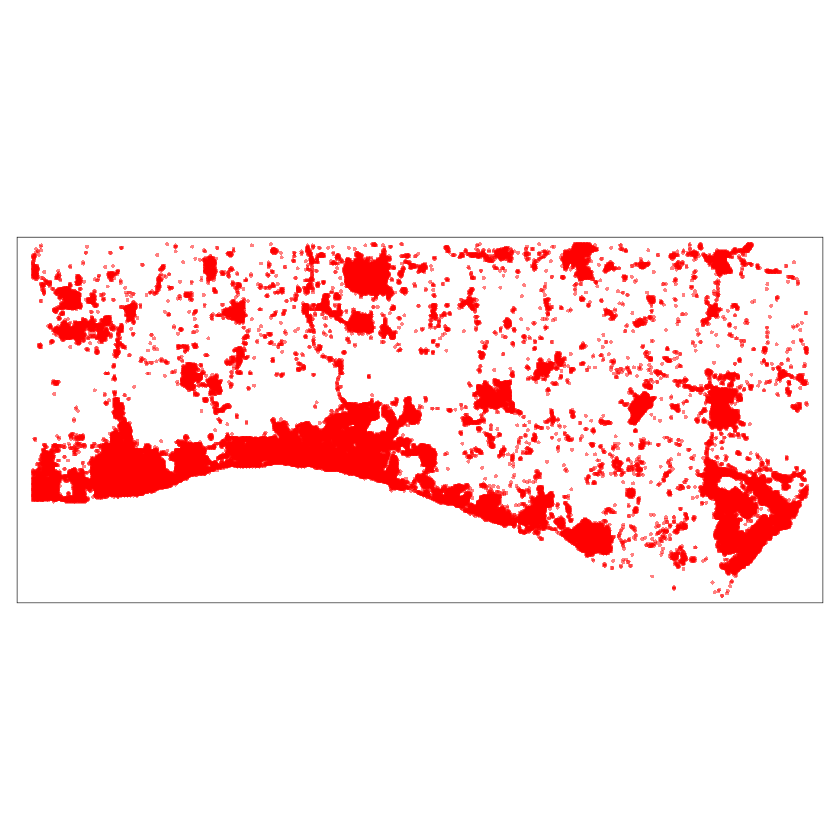

In [4]:
# Load population points
pop_fp = file.path(data_path, "Brighton_pop_points_2020.gpkg")
pop_points = read_sf(pop_fp)

# Plot the points
tm_shape(pop_points) + tm_symbols(size=0.05, col="red", border.lwd=0, alpha=0.5) 

Let's also check how the attribute table of the data looks like:

In [ ]:
# Check the first 5 rows
head(pop_points)

Next, we will geocode the address for Brighton Railway station. For doing this, we can use `tidygeocoder` library and its handy `.geocode()` -function:

In [6]:
# Find coordinates of the main railway station 
station = data.frame(address = "Railway station, Brighton, UK")
station = geocode(station, address, method = "osm")

# Plot
m <- leaflet(station) %>%
     addTiles() %>%
     addCircles(lng = ~long, lat = ~lat, radius=80, col="red")
m

Passing 1 address to the Nominatim single address geocoder

Query completed in: 1 seconds



HTML widgets cannot be represented in plain text (need html)

In [7]:
# Create a sf object out of the coordinates
station = st_as_sf(station, coords = c("long", "lat"), crs = "EPSG:4326")
head(station)

address,geometry
<chr>,<POINT [°]>
"Railway station, Brighton, UK",POINT (-0.1407393 50.82886)


As a last thing, we need to assign a unique `id` for our station object:

In [8]:
station["id"] = 0
head(station)

address,geometry,id
<chr>,<POINT [°]>,<dbl>
"Railway station, Brighton, UK",POINT (-0.1407393 50.82886),0


## Prepare a routable network with r5r

- Next, we will prepare the routable network with `r5r`. First, we will allow the r5 engine to use 6 Gb of memory. Then we import the `r5r` library and prepare the routable network by calling `setup_r5()` -function:

In [9]:
# Allow 6 GiB of memory
options(java.parameters = "-Xmx6G")

In [ ]:
# After allocating the memory import the r5r
library(r5r)

In [11]:
# Create the routable network by indicating the path where OSM, GTFS and possible DEM data are stored
r5r_core = setup_r5(data_path = data_path)

Using cached R5 version from /home/hentenka/.conda/envs/mamba/envs/r5edu/lib/R/library/r5r/jar/r5-v6.7-all.jar


Finished building network.dat at data/Brighton/network.dat



## Calculate travel time matrix

After building the routable network, we can do the routing. For this, we need to have `x` and `y` columns for both origins and destinations:

In [12]:
# Parse the lat, lon coordinates (i.e. y, x)
station[c("x", "y")] = st_coordinates(station)
head(station)

address,geometry,id,x,y
<chr>,<POINT [°]>,<dbl>,<dbl>,<dbl>
"Railway station, Brighton, UK",POINT (-0.1407393 50.82886),0,-0.1407393,50.82886


In [13]:
# Our population points already has the `x` and `y` columns
head(pop_points)

x,y,population,id,geom
<dbl>,<dbl>,<dbl>,<dbl>,<POINT [°]>
-0.4991666,50.97250,10.112679,0,POINT (-0.4991666 50.9725)
-0.4991666,50.97167,19.579712,1,POINT (-0.4991666 50.97167)
-0.4991666,50.97083,12.178864,2,POINT (-0.4991666 50.97083)
-0.4991666,50.96833,5.552000,3,POINT (-0.4991666 50.96833)
-0.4991666,50.96750,2.551825,4,POINT (-0.4991666 50.9675)
-0.4991666,50.96667,2.637614,5,POINT (-0.4991666 50.96667)


In [14]:
# Set parameters
mode = c("WALK", "TRANSIT")
max_walk_time = 30 # minutes
max_trip_duration = 120 # minutes
departure_datetime = as.POSIXct("01-12-2022 8:30:00",
                                 format = "%d-%m-%Y %H:%M:%S")

# Calculate the travel time matrix by Transit
ttm = travel_time_matrix(r5r_core = r5r_core,
                          origins = station,
                          destinations = pop_points,
                          mode = mode,
                          departure_datetime = departure_datetime,
                          max_walk_time = max_walk_time,
                          max_trip_duration = max_trip_duration)

head(ttm)

Warning message in assign_points_input(origins, "origins"):
“'origins$id' forcefully cast to character.”
Warning message in assign_points_input(destinations, "destinations"):
“'destinations$id' forcefully cast to character.”


from_id,to_id,travel_time_p50
<chr>,<chr>,<int>
0,8549,112
0,8550,113
0,8551,113
0,8552,114
0,8553,112
0,8554,112


- Now we can join the travel time information back to the population points

In [15]:
# Convert 'to_id' back to integer which is needed for the join
ttm[, to_id:=as.numeric(to_id)]

# Make inner join - the key in left is 'id' and in right 'to_id'
geo = inner_join(pop_points, ttm, by=c(id = "to_id"))
head(geo)

x,y,population,id,geom,from_id,travel_time_p50
<dbl>,<dbl>,<dbl>,<dbl>,<POINT [°]>,<chr>,<int>
-0.3366666,50.88750,4.990854,8549,POINT (-0.3366666 50.8875),0,112
-0.3366666,50.88667,6.199840,8550,POINT (-0.3366666 50.88667),0,113
-0.3366666,50.88583,10.519016,8551,POINT (-0.3366666 50.88583),0,113
-0.3366666,50.88500,13.427657,8552,POINT (-0.3366666 50.885),0,114
-0.3366666,50.88417,13.396514,8553,POINT (-0.3366666 50.88417),0,112
-0.3366666,50.88333,7.725784,8554,POINT (-0.3366666 50.88333),0,112


- Finally, we can visualize the travel time map and investigate how the railway station in Brighton can be accessed from different parts of the region, by public transport.

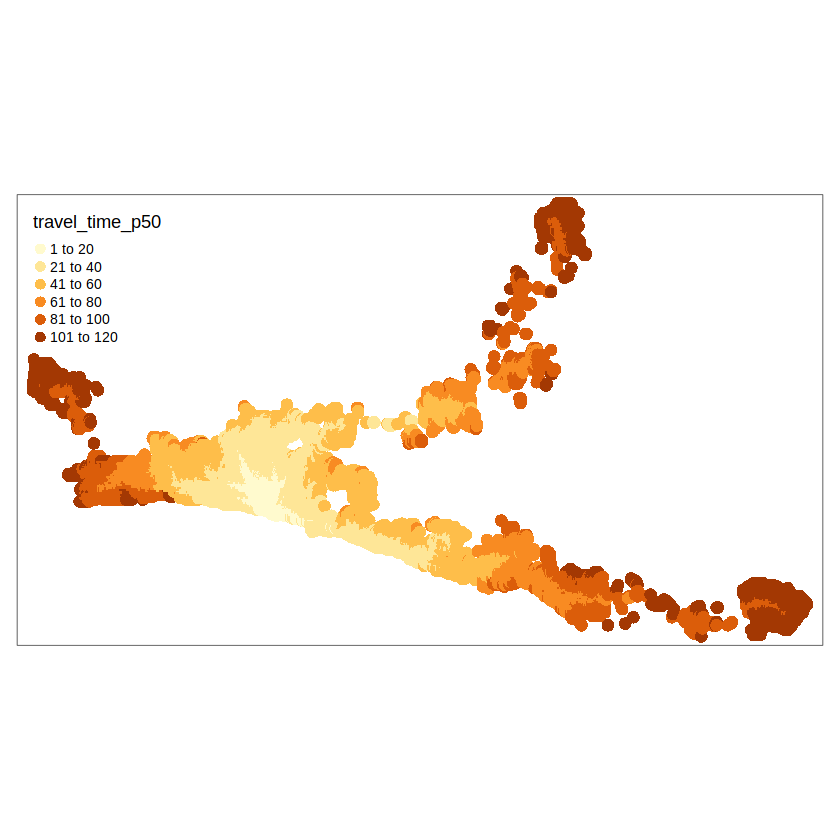

In [16]:
# Plot the travel times
tm_shape(geo) + tm_symbols(col="travel_time_p50", size=0.5, border.lwd=0)

## Calculate travel times by bike

In a very similar manner, we can calculate travel times by cycling. We only need to modify our `TravelTimeMatrixComputer` object a little bit. We specify the cycling speed by using the parameter `speed_cycling` and we change the `transport_modes` parameter to correspond to `[LegMode.BICYCLE`. This will initialize the object for cycling analyses:

In [17]:
# Define parameters
mode = "BICYCLE"
max_trip_duration = 120 # minutes
max_bike_time = 120 # minutes
departure_datetime <- as.POSIXct("01-12-2022 8:30:00",
                                 format = "%d-%m-%Y %H:%M:%S")
bike_speed = 16 # km/h

# Calculate the travel time matrix by Transit
ttm = travel_time_matrix(r5r_core = r5r_core,
                          origins = station,
                          destinations = pop_points,
                          mode = mode,
                          departure_datetime = departure_datetime,
                          max_bike_time = max_bike_time,
                          max_trip_duration = max_trip_duration,
                          bike_speed = bike_speed
                        )

head(ttm)

Warning message in assign_points_input(origins, "origins"):
“'origins$id' forcefully cast to character.”
Warning message in assign_points_input(destinations, "destinations"):
“'destinations$id' forcefully cast to character.”


from_id,to_id,travel_time_p50
<chr>,<chr>,<int>
0,6174,119
0,6247,119
0,6316,119
0,6380,120
0,6437,120
0,6438,119


- Let's again make a table join with the population grid

In [18]:
# Convert 'to_id' back to integer which is needed for the join
ttm[, to_id:=as.numeric(to_id)]

# Make inner join - the key in left is 'id' and in right 'to_id'
geo = inner_join(pop_points, ttm, by=c(id = "to_id"))
head(geo)

x,y,population,id,geom,from_id,travel_time_p50
<dbl>,<dbl>,<dbl>,<dbl>,<POINT [°]>,<chr>,<int>
-0.3941666,50.80667,20.31480,6174,POINT (-0.3941666 50.80667),0,119
-0.3933333,50.80667,20.58511,6247,POINT (-0.3933333 50.80667),0,119
-0.3925000,50.80667,20.49868,6316,POINT (-0.3925 50.80667),0,119
-0.3916666,50.80833,26.29699,6380,POINT (-0.3916666 50.80833),0,120
-0.3908333,50.80917,25.50407,6437,POINT (-0.3908333 50.80917),0,120
-0.3908333,50.80833,25.89168,6438,POINT (-0.3908333 50.80833),0,119


- And plot the data

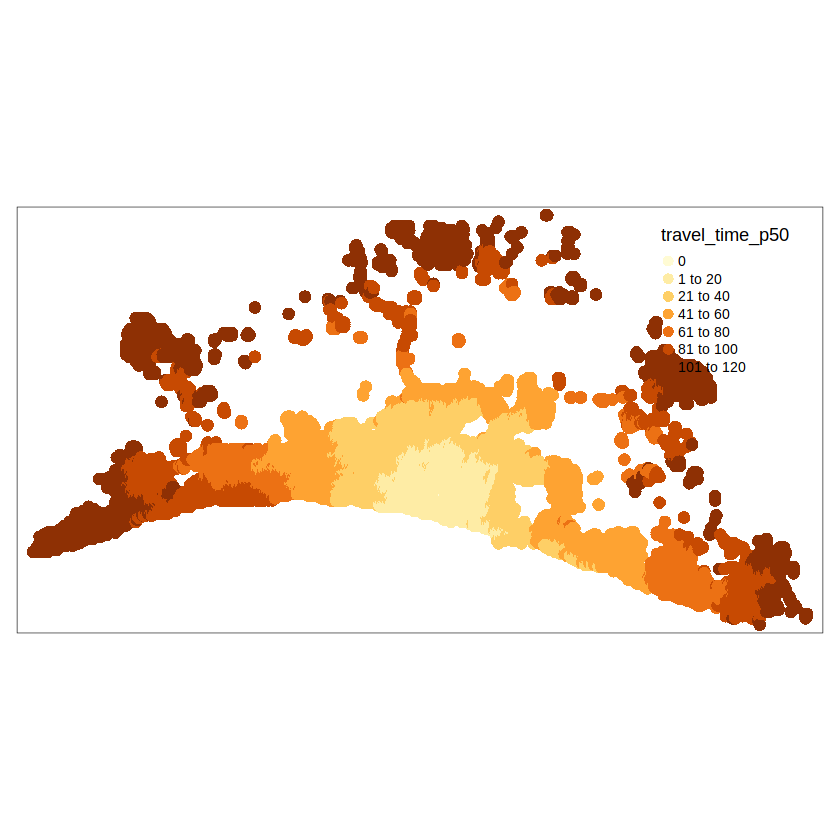

In [19]:
# Plot the travel times
tm_shape(geo) + tm_symbols(col="travel_time_p50", size=0.5, border.lwd=0)

## Calculate catchment areas

One quite typical accessibility analysis is to find out catchment areas for multiple locations, such as schools. In the below, we will extract all libraries in Brighton area and calculate travel times from all grid cells to the closest one. As a result, we have catchment areas for each school.

Let's start by preparing data. In the following, we will:

- Download OSM data about locations of schools in Brighton area, using `osmdata` -package. 
- We will also rename the column `osm_id` to `id` because `r5r` expects to find a unique-id from column `id` (similarly as `r5py`)
- Lastly, we will extract the x and y coordinates from the geometries

In [23]:
# Extent of the data for Brighton
# (minx, miny, maxx, maxy)
bounds = c(-0.49975, 50.73,  0.3469234, 50.98)

# Retrieve schools from OSM
schools = opq(bbox = bounds) |>
  add_osm_feature(key = "amenity", value="school") |>
  osmdata_sf()

# Keep only `osm_polygons` object from the result
schools = schools$osm_polygons

# Rename 'osm_id' to 'id' 
schools = rename(schools, id=osm_id)

# Extract the lat and lon coordinates of the Polygon centroids
schools[c("lon", "lat")] = st_coordinates(st_centroid(schools))
head(schools)

Warning message in st_centroid.sf(schools):
“st_centroid assumes attributes are constant over geometries of x”


id       name                                          addr.city   
4564528  4564528  Brighton College Sports Ground                NA          
4796362  4796362  Burgess Hill Girls                            Burgess Hill
22767691 22767691 Herstmonceux Church of England Primary School NA          
23003318 23003318 East Preston Schools                          NA          
23261552 23261552 Ratton School                                 Eastbourne  
25772335 25772335 Longhill High School                          Brighton    
         addr.country addr.housename addr.housenumber addr.locality addr.place
4564528  NA           NA             NA               NA            NA        
4796362  NA           NA             NA               NA            NA        
22767691 NA           NA             NA               NA            NA        
23003318 NA           NA             NA               NA            NA        
23261552 NA           NA             NA               NA            NA        
25772335 NA           NA             NA               NA            NA        
         addr.postcode addr.province geometry                       ⋯
4564528  NA            NA            POLYGON ((-0.0958142 50.820... ⋯
4796362  RH15 0EG      NA            POLYGON ((-0.1259993 50.950... ⋯
22767691 BN27 4LG      NA            POLYGON ((0.3223906 50.8892... ⋯
23003318 NA            NA            POLYGON ((-0.4829187 50.813... ⋯
23261552 BN21 2XR      NA            POLYGON ((0.2611432 50.7898... ⋯
25772335 BN2 7FR       NA            POLYGON ((-0.067842 50.8190... ⋯
         start_date surface toilets.wheelchair
4564528  NA         NA      NA                
4796362  NA         NA      NA                
22767691 NA         NA      NA                
23003318 NA         NA      NA                
23261552 NA         NA      NA                
25772335 NA         NA      NA                
         website                                   wheelchair wikidata 
4564528  NA                                        NA         NA       
4796362  NA                                        NA         NA       
22767691 https://www.herstmonceux.e-sussex.sch.uk/ NA         Q66223920
23003318 NA                                        NA         NA       
23261552 http://www.ratton.e-sussex.sch.uk         NA         Q7296036 
25772335 http://www.longhill.org.uk/               NA         Q6673876 
         wikipedia        geometry                       lon         lat     
4564528  NA               POLYGON ((-0.0958142 50.820... -0.09774609 50.81997
4796362  NA               POLYGON ((-0.1259993 50.950... -0.12438086 50.95140
22767691 NA               POLYGON ((0.3223906 50.8892...  0.32290302 50.88901
23003318 NA               POLYGON ((-0.4829187 50.813... -0.48161284 50.81270
23261552 en:Ratton School POLYGON ((0.2611432 50.7898...  0.25971056 50.79073
25772335 NA               POLYGON ((-0.067842 50.8190... -0.06654489 50.81820

In [24]:
# Plot the data
m <- leaflet(schools) %>%
     addTiles() %>%
     addCircles(lng = ~lon, lat = ~lat, radius=20, col="blue")
m

HTML widgets cannot be represented in plain text (need html)

As a last thing, we need to convert the `sf` object into a regular `data.frame`, which we can do by dropping the `geometry` column:

In [25]:
schools = schools %>% st_drop_geometry()
class(schools)

[1] "data.frame"

- Next, we can initialize our travel time matrix calculator using the libraries as the origins:

In [26]:
# Set parameters
mode = c("WALK", "TRANSIT")
max_walk_time = 30 # minutes
max_trip_duration = 120 # minutes
departure_datetime = as.POSIXct("01-12-2022 8:30:00",
                                 format = "%d-%m-%Y %H:%M:%S")

# Calculate the travel time matrix by Transit
ttm = travel_time_matrix(r5r_core = r5r_core,
                          origins = schools,
                          destinations = pop_points,
                          mode = mode,
                          departure_datetime = departure_datetime,
                          max_walk_time = max_walk_time,
                          max_trip_duration = max_trip_duration)

head(ttm)

Warning message in assign_points_input(destinations, "destinations"):
“'destinations$id' forcefully cast to character.”


from_id,to_id,travel_time_p50
<chr>,<chr>,<int>
4564528,10559,119
4564528,10579,119
4564528,10584,119
4564528,10602,119
4564528,10603,119
4564528,10604,118


In [27]:
# How many rows do we have?
nrow(ttm)

[1] 2095545

- As we can see, there are more than 2 million rows of data, which comes as a result of all connections between origins and destinations. Next, we want aggregate the data and keep only travel time information to the closest school: 

In [28]:
# Find out the travel time to closest school
closest = aggregate(ttm$travel_time_p50, by=list(ttm$to_id), FUN=min, na.rm=TRUE)

In [29]:
# Rename columns
closest = closest %>% rename(time=x, id=Group.1) 
class(closest)

[1] "data.frame"

In [30]:
head(closest)

,id,time
,<chr>,<int>
1,10,4
2,100,3
3,10000,21
4,10001,19
5,10002,16
6,10003,15


In [31]:
# Convert 'to_id' back to integer which is needed for the join
closest["id"] = as.integer(closest$id)
head(closest)

,id,time
,<int>,<int>
1,10,4
2,100,3
3,10000,21
4,10001,19
5,10002,16
6,10003,15


Then we can make a table join with the grid in a similar manner as previously and visualize the data:

In [32]:
# Make inner join - the key in left is 'id' and in right 'to_id'
geo = inner_join(pop_points, closest, by="id")
head(geo)

x,y,population,id,geom,time
<dbl>,<dbl>,<dbl>,<dbl>,<POINT [°]>,<int>
-0.4991666,50.96667,2.637614,5,POINT (-0.4991666 50.96667),11
-0.4991666,50.96583,2.588078,6,POINT (-0.4991666 50.96583),10
-0.4991666,50.96500,2.529992,7,POINT (-0.4991666 50.965),9
-0.4991666,50.96417,4.308811,8,POINT (-0.4991666 50.96417),8
-0.4991666,50.96333,7.568533,9,POINT (-0.4991666 50.96333),6
-0.4991666,50.96250,5.156054,10,POINT (-0.4991666 50.9625),4


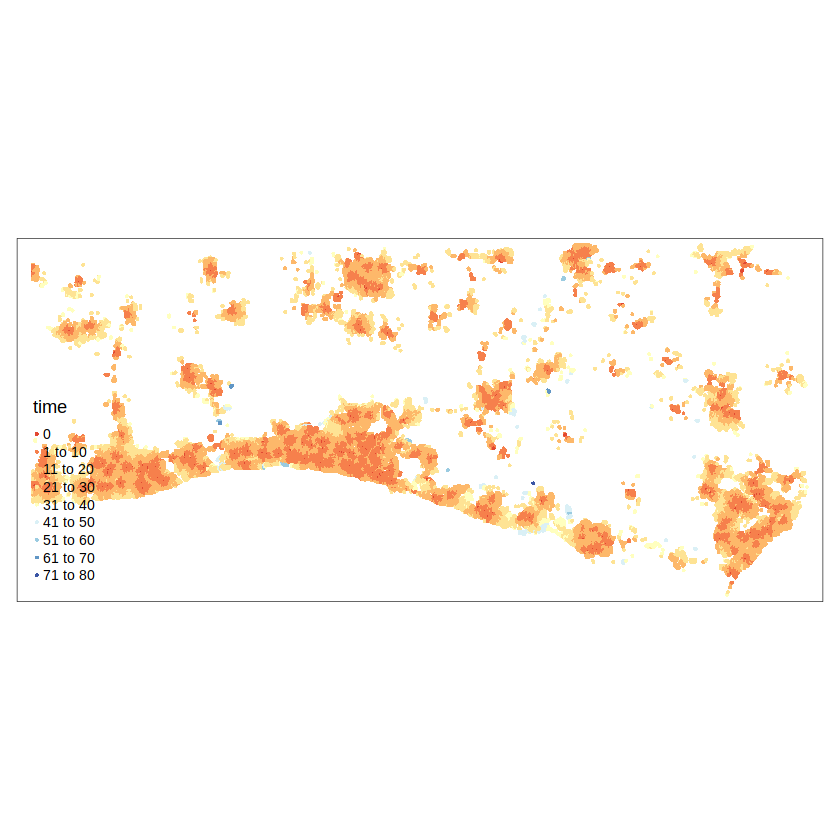

In [33]:
# Plot the travel times which are classified into 10 classes 
tm_shape(geo) + tm_symbols(col="time", size=0.05, border.lwd=0, style="pretty", n=10, palette="RdYlBu") 

That's it! As you can, see now we have a nice map showing the catchment areas for each school.